In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from scipy.integrate import solve_ivp
from scipy import optimize
import ray
from ray.util.multiprocessing import Pool
from scipy.optimize import least_squares
from scipy.interpolate import griddata

In [37]:
Msun = 1.988*1e33
M = 3*Msun
Rsun = 6.96e10
Lsun = 3.826e33
X = 0.3500
Y = 0.5500
Z = 1 - X - Y #Z=0.1000 
#We're using Table #52 from OPAL 

In [38]:
def txttodf(filename):
    with open(filename) as f:
        lines = f.readlines()
    
    dict = {}
    for k in range(126):
        arr = []
        log_T = []
        table_name = 'Table '+str(k+1)
        for j in range(70):
            arr1 = []
            for i in lines[6+77*k+j].split()[1:]: arr1.append(float(i))
            log_T.append(float(lines[6+77*k+j].split()[0]))
            arr.append(np.array(arr1))
            dict[table_name] = pd.DataFrame(arr)
    
    log_R = []
    for i in lines[4].split()[1:]: log_R.append(float(i))
    
    return dict, log_R, log_T

In [39]:
filename = 'GN93hz.txt' 
diction, logR_Table, logT_Table = txttodf(filename) 
T52 = diction['Table 52'] 

In [40]:
opacity_T = T52.to_numpy()

In [41]:
T52

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-0.977,-1.109,-1.281,-1.476,-1.682,-1.888,-2.085,-2.256,-2.374,-2.406,-2.328,-2.150,-1.889,-1.586,-1.165,-0.726,-0.269,0.103,0.440
1,-0.831,-0.850,-0.900,-0.992,-1.124,-1.279,-1.442,-1.588,-1.689,-1.724,-1.666,-1.536,-1.340,-1.123,-0.832,-0.493,-0.096,0.322,0.658
2,-0.813,-0.805,-0.797,-0.793,-0.797,-0.825,-0.879,-0.938,-0.979,-0.981,-0.930,-0.829,-0.681,-0.509,-0.304,-0.043,0.245,0.590,0.990
3,-0.815,-0.802,-0.783,-0.754,-0.706,-0.629,-0.532,-0.432,-0.343,-0.263,-0.184,-0.091,0.026,0.166,0.317,0.526,0.746,0.994,1.276
4,-0.808,-0.804,-0.787,-0.755,-0.696,-0.590,-0.420,-0.190,0.062,0.289,0.467,0.601,0.722,0.840,0.961,1.132,1.310,1.513,1.744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,-0.659,-0.659,-0.659,-0.660,-0.660,-0.660,-0.659,-0.658,-0.653,-0.642,-0.618,-0.583,-0.534,-0.461,-0.357,NaN,NaN,NaN,NaN
66,-0.679,-0.679,-0.679,-0.679,-0.680,-0.680,-0.679,-0.678,-0.675,-0.666,-0.650,-0.625,-0.591,-0.535,-0.459,NaN,NaN,NaN,NaN
67,-0.732,-0.733,-0.733,-0.733,-0.733,-0.733,-0.733,-0.732,-0.731,-0.726,-0.721,-0.717,-0.714,-0.690,-0.690,NaN,NaN,NaN,NaN
68,-0.803,-0.803,-0.803,-0.803,-0.803,-0.804,-0.803,-0.803,-0.803,-0.804,-0.808,-0.823,-0.849,-0.889,-1.219,NaN,NaN,NaN,NaN


In [42]:
logR_Table

[-8.0,
 -7.5,
 -7.0,
 -6.5,
 -6.0,
 -5.5,
 -5.0,
 -4.5,
 -4.0,
 -3.5,
 -3.0,
 -2.5,
 -2.0,
 -1.5,
 -1.0,
 -0.5,
 0.0,
 0.5,
 1.0]

In [43]:
logT_Table

[3.75,
 3.8,
 3.85,
 3.9,
 3.95,
 4.0,
 4.05,
 4.1,
 4.15,
 4.2,
 4.25,
 4.3,
 4.35,
 4.4,
 4.45,
 4.5,
 4.55,
 4.6,
 4.65,
 4.7,
 4.75,
 4.8,
 4.85,
 4.9,
 4.95,
 5.0,
 5.05,
 5.1,
 5.15,
 5.2,
 5.25,
 5.3,
 5.35,
 5.4,
 5.45,
 5.5,
 5.55,
 5.6,
 5.65,
 5.7,
 5.75,
 5.8,
 5.85,
 5.9,
 5.95,
 6.0,
 6.1,
 6.2,
 6.3,
 6.4,
 6.5,
 6.6,
 6.7,
 6.8,
 6.9,
 7.0,
 7.1,
 7.2,
 7.3,
 7.4,
 7.5,
 7.6,
 7.7,
 7.8,
 7.9,
 8.0,
 8.1,
 8.3,
 8.5,
 8.7]

In [44]:
logT_Table = np.array(logT_Table)
logT_Table

array([3.75, 3.8 , 3.85, 3.9 , 3.95, 4.  , 4.05, 4.1 , 4.15, 4.2 , 4.25,
       4.3 , 4.35, 4.4 , 4.45, 4.5 , 4.55, 4.6 , 4.65, 4.7 , 4.75, 4.8 ,
       4.85, 4.9 , 4.95, 5.  , 5.05, 5.1 , 5.15, 5.2 , 5.25, 5.3 , 5.35,
       5.4 , 5.45, 5.5 , 5.55, 5.6 , 5.65, 5.7 , 5.75, 5.8 , 5.85, 5.9 ,
       5.95, 6.  , 6.1 , 6.2 , 6.3 , 6.4 , 6.5 , 6.6 , 6.7 , 6.8 , 6.9 ,
       7.  , 7.1 , 7.2 , 7.3 , 7.4 , 7.5 , 7.6 , 7.7 , 7.8 , 7.9 , 8.  ,
       8.1 , 8.3 , 8.5 , 8.7 ])

In [45]:
logR_Table = np.array(logR_Table)
logR_Table

array([-8. , -7.5, -7. , -6.5, -6. , -5.5, -5. , -4.5, -4. , -3.5, -3. ,
       -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ])

In [11]:
# interpolation = scipy.interpolate.RegularGridInterpolator((logR_Table,logT_Table),opacity.T)

In [12]:
# #create a function to accept inputs from density and temperature
# def calc_opacity(rho, T):

#     log_R = np.log10(rho/(1e-6*T)**3)
#     log_T = np.log10(T)
#     interpolation = scipy.interpolate.RegularGridInterpolator((logR_Table,logT_Table),opacity_T.T)
#     print(log_R,log_T)
#     opacity = 10**interpolation([log_R, log_T])
#     return opacity

In [13]:
# #create a function to accept inputs from density and temperature
# def calc_opacity(log_T, rho):
#     log_R = np.log10(rho/(1e-6*10**log_T)**3)
    
#     opacity = interpolation([log_R, log_T])
#     return opacity

In [14]:
# import numpy as np
# import pandas as pd
# from scipy.interpolate import griddata

# rosseland = pd.read_csv('/Users/lakeishamramosrosado/Spring 2023 Class/Stellar Structure and Evolution/Stellar Model Report/combined_OPAL_F05_X0.7_Z0.02_logT8.7-2.7.txt', index_col=0)
# # rosseland = pd.read_csv('./opacities/OPAL_GN93.7.02.txt', index_col=0)
# # make the columns floats not strings (useful later)
# rosseland.columns = rosseland.columns.astype(float)

# # setup the grid like scipy interpolate requires it - <function scipy.interpolate._ndgriddata.griddata(points, values, xi, method='linear', fill_value=nan, rescale=False)>
# pts = []
# vals = []
# for i in range(len(rosseland.columns.values)):
#     for j in range(len(rosseland.index.values)):
#         points.append([rosseland.columns.values[i], rosseland.index.values[j]])
#         values.append(rosseland.values[j][i])

        
# def interp_k(rho_i, T_i, method='linear'):
#     '''
#     A function to interpolate across the Rosseland
#     opacity grid using scipy.interpolate.interpn
#     '''
#     # calc logR (R=rho/T_6^3)
#     logR_i = np.log10(rho_i/(T_i/1e6)**3)
#     # calc logT
#     logT_i = np.log10(T_i)
#     print(logR_i,logT_i)

#     # arrange interpolation point in array
#     new_point = (logT_i,logR_i)
#     # compute interpolation
#     interpolated_points = 10**griddata(points, values, (logR_i, logT_i), method=method)

#     return interpolated_points

In [247]:
b=np.empty((3,3,))
b[:] = np.nan
b

array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])

In [248]:
b.any()

True

In [561]:
calc_opacity(-2,4)

<ipython-input-560-96a9523d4955>:12: RuntimeWarning: invalid value encountered in log10
  log_R = np.log10(rho/(1e-6*T)**3)


array(-0.977)

In [562]:
#create a function to accept inputs from density and temperature and interpolate

# Setup the grid like scipy interpolate requires it - <function scipy.interpolate._ndgriddata.griddata(points, values, xi, method='linear', fill_value=nan, rescale=False)>
pts = []
vals = []
for i in range(len(logR_Table)):
    for j in range(len(logT_Table)):
        pts.append([logR_Table[i], logT_Table[j]])
        vals.append(T52.values[j][i])

def calc_opacity(rho, T):
    log_R = np.log10(rho/(1e-6*T)**3)
    log_T = np.log10(T)
    
    try:
        opacity = 10**griddata(pts, vals, (log_R, log_T))
    except np.nan(opacity):
        print('nan encountered')
        print(log_R,log_T)

        
    return opacity

In [16]:
#Equations from chapter 18 to use for part 4 calculation

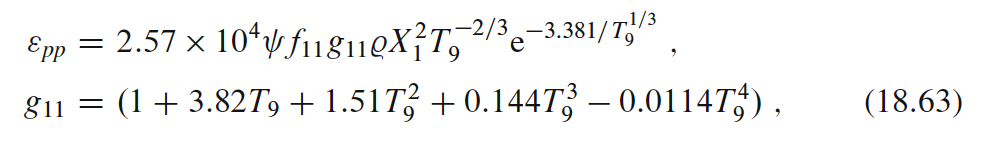

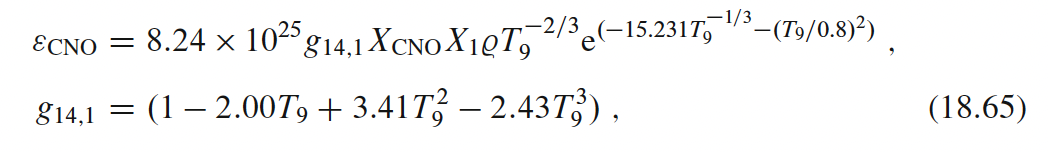

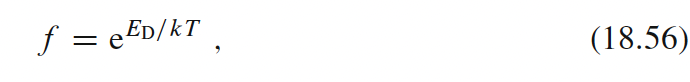

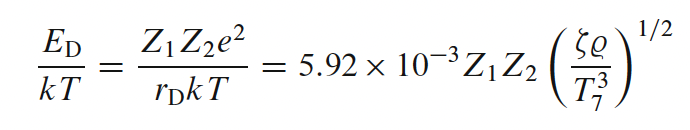

In [47]:
#Define a function to calculate g11

def g11(T):
    T9 = T*1e-9
    g11 = 1 + 3.82*T9 + 1.51*(T9**2) + 0.144*(T9**3) - 0.011*(T9**4)
    
    return g11

In [48]:
#Define a function to calculate g14

def g14(T):
    T9 = T*1e-9
    g14 = 1 - 2*T9 + 3.41*(T9**2) - 2.43*(T9**3)
    
    return g14

In [49]:
#Define a function to calculate f11

def f11(rho,T):
    T7 = T*1e-7
    Z1 = 1 #assuming pp chain
    Z2 = 1 #assuming pp chain
    zeta = 1 #assuming from book
    f11 = np.exp((5.92e-3) * Z1 * Z2 * np.sqrt(zeta*rho/T7**3))
    
    return f11

In [58]:
#Define a function to calculate the energy generation rate from the PP chain

#testing values from book to replicate results
# psi = 1
# Z1 = 1
# Z2 = 1
# zeta = 1
# X1 = 1
#XCNO = 0.01

def e_pp(rho,T):
    psi = 1
    T9 = T*1e-9
    f_11 = f11(rho,T)
    g_11 = g11(T)
    X1 = 0.35 #using our value
    e_pp = (2.57e4) * psi * f_11 * g_11 * rho*(X1**2)*(T9**(-2/3))*np.exp(-3.381/(T9**(1/3)))
    
    return e_pp

In [59]:
#Define a function to calculate the energy generation rate from the CNO cycle

def e_cno(rho,T):
    T9 = T*1e-9
    g_14 = g14(T)
    Z_ = 0.1 
    XCNO = (2/3) * Z_
    X1 = 0.35
    e_cno = (8.24e25) * g_14 * XCNO * X1 * rho * (T9**(-2/3)) * np.exp((-15.231*(T9**(-1/3)))-((T9/0.8)**2))
    
    return e_cno

In [60]:
#Energy generation rate from both pp chain and cno cycle

def energy_rate(rho,T):
    epp = e_pp(rho,T)
    ecno = e_cno(rho,T)
    
    return epp+ecno

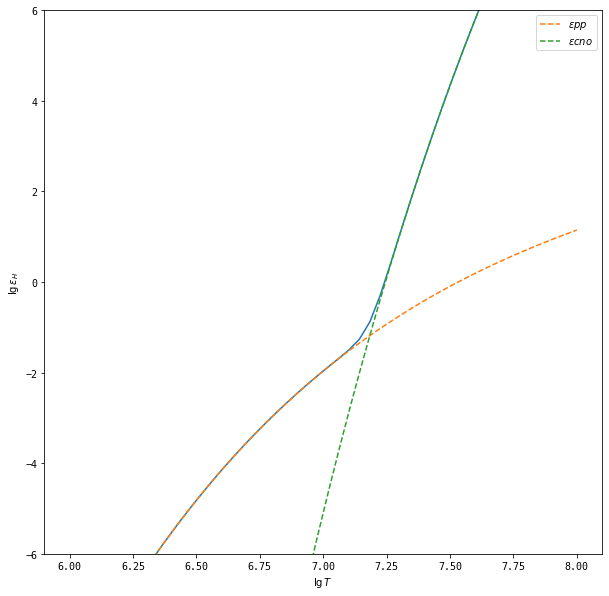

In [1028]:
#Now let's replicate the plot 18.8 in KWW's book to make sure functions are correct
plt.figure(figsize = (10,10))
x = np.linspace(6,8,50)
y = np.log10(energy_rate(1,10**x))

plt.plot(x,y)
plt.plot(x, np.log10(e_pp(1,10**x)),ls = '--', label = r'$\epsilon pp $')
plt.plot(x, np.log10(e_cno(1,10**x)), ls = '--', label = r'$\epsilon cno$')
plt.xlabel(r'$\lg T$')
plt.ylabel(r'$\lg \epsilon_H$')
plt.ylim(-6,6)
plt.legend()

In [62]:
#Define a function to calculate density, assumed complete ionization so mu can be approximated to ~ 4/3+5x 

def rho_(P,T,X=0.35):
    Na = 6.022e23
    k = 1.380658e-16
    a = 7.5646e-15
    mu = 4/(3 + 5* X)
    rho = (P - (a*T**4/3))*(mu/(Na*k*T))
    
    return rho

In [63]:
def delrad(m,l,P,rho,T):
    a = 7.5646e-15
    c  = 2.99792458e10
    G = 6.67259e-8
  
    k = calc_opacity(rho,T)
  
    delrad = (3/(16*np.pi*a*c*G))*((P*k)/T**4)*(l/m)
    
    return delrad

In [64]:
del_ad = ((5/3)-1)/(5/3)

In [835]:
#Let's create the load1 = load_in and load2 = load_out functions
#We're going to use the constant-density model to get load1
#We're going to use homology relations to get load2
#Assuming full ionization in the center 

def load_in(Tc,Pc, factor=1e-12):
    G = 6.67259e-8
    X = 0.35
    a = 7.5646e-15
    c  = 2.99792458e10
    
    Ms = Msun*factor #setting so we're no in the center but just outside of it
    rho_c = rho_(Pc,Tc,X=0.35)
   
    ep = energy_rate(rho_c,Tc) #energy rate from pp and cno
    l = ep*Ms #luminosity at core 

    #from book eq 11.3
    P = Pc - (3*G/8*np.pi)*((4*np.pi*rho_c)/3)**(4/3)*(Ms**(2/3))
    
    #from book eq 11.6
    r = ((3*Ms)/(4*np.pi*rho_c))**(1/3)
   
    #now for temperature we have to consider if we have a radiative or convective core
    #so we use the definition of del_rad in 4.30 
   
    del_rad = delrad(Ms,l,P,rho_c,Tc)
    del_ad = ((5/3)-1)/(5/3) #assuming ideal gas and that gamma1=gamma2=gamma3=gamma=5/3 (eq 3.96)
   
    #so now let's check which one dominates
    
    if del_rad < del_ad:

    #for radiative let's look at 11.9 (radiative part)
        kc = calc_opacity(rho_c, Tc)
        T = (Tc**4 - (1/(2*a*c))*(3/(4*np.pi))**(2/3)*kc*ep*(rho_c**(4/3))*(Ms**(2/3)))**(1/4)
    else:
       
    #for convective use 11.9 (convective part)    
        T = np.exp(np.log(Tc)- ((np.pi/6)**(1/3))*G*del_ad*(rho_c**(4/3))*(Ms**(2/3))*(1/Pc))
    
    #returns our 4 dependent variables in array form
    return np.array([l,P,r,T])

In [631]:
rho_PgPrad(10**1.055688,10**7.335298)

2.4844228492782844e+16

In [634]:
load_in(10**7.33598,rho_PgPrad(10**1.055688,10**7.335298))

0.14635307305778852


array([1.01432516e+24, 2.48442264e+16, 3.47105396e+06, 2.16760428e+07])

In [937]:
def rho_PgPrad(rho,T):
    a = 7.5646e-15
    Na = 6.022e23
    k = 1.380658e-16
    X = 0.35
    mu = 4/(3 + 5* X)
    P_gas = (1/3)*a*(T**4) + (Na*k*rho*T)/mu
    
    return P_gas

In [603]:
def rho_opacity(rho,T):
    G = 6.67259e-8
    sb = 5.67051e-5
    c  = 2.99792458e10
 
    
    k = 1.380658e-16
    gs = G*Ms/(Rs**2) #surface gravity
    T_eff = (Ls/(4*np.pi*sb*(Rs**2)))**(1/4)
   
    kappa = calc_opacity(rho, T_eff)
    
    P_photo = (2/3)*(gs/kappa)*(1+(k*Ls)/(4*np.pi*c*G*Ms))
    
    return P_photo 

In [595]:
def rho_min(rho,T):
    
    diff = 1 - rho_opacity(rho,T)/rho_PgPrad(rho,T)
    
    return np.abs(diff**2)

In [608]:
def load_out(Ms,Ls,Rs, factor=0.9999):
    X = 0.35
    mu = 4/(3 + 5* X)
    G = 6.67259e-8
    sb = 5.67051e-5
    c  = 2.99792458e10
    a = 7.5646e-15
    Na = 6.022e23
    k = 1.380658e-16
    gs = G*Ms/(Rs**2) #surface gravity
    T_eff = (Ls/(4*np.pi*sb*(Rs**2)))**(1/4)
  
    #let's find the difference between density using opacity and density using the equation of state
    
#     def rho_min(rho):
# #         kappa = calc_opacity(rho, T_eff)
# #         #Lets's use the eq 4.48 from the book to find the pressure at photosphere
# #         P_photo = (2/3)*(gs/kappa)*(1+(k*Ls)/(4*np.pi*c*G*Ms))
# #         #Now let's use eq 4.55 to find the radiation pressure
# #         P_gas_rad = (1/3)*a*(T_eff**4) + (Na*k*rho*T_eff)/mu
#         diff = 1 - P_photo/P_gas_rad
    
#         return np.abs(diff**2)

    #now let's use a minimizer to find the min diff between them
    rho_final = optimize.minimize(rho_min, 1e-8, args = (T_eff), method='Nelder-Mead', bounds=[(1e-13,1e-5)])

    if rho_final.success:
        rho = rho_final.x[0]
    else:
        print('no rho')
        
    kappa = calc_opacity(rho, T_eff)
    P = (2/3)*(gs/kappa)*(1+(k*Ls)/(4*np.pi*c*G*Ms))
    
    #returns our 4 dependent variables in array form
    return np.array([Ls,P,Rs,T_eff])

In [68]:
#Lets define a function for the 4 differential equations

def derivs(M,var):
    G = 6.67259e-8
    l,P,r,T = var
    
    rho = rho_(P,T,X = 0.35)
    del_rad = delrad(M,l,P,rho,T)
    del_f = np.minimum(del_rad,del_ad)
    
    dldm = energy_rate(rho,T)
    dPdm = (-G*M)/(4*np.pi*(r**4))
    drdm = 1/(4*np.pi*(r**2)*rho)
    dTdm = ((-G*M*T)/(4*np.pi*(r**4)*P))*del_f
    
    derivs = np.array([dldm,dPdm,drdm,dTdm])
    
    return derivs

In [ ]:
([Ls, Pc, Rs, Tc])
[1.78924313e+35 4.47147063e+15 1.58653691e+11 9.28264343e+06]

In [578]:
#Now finally, let's create our shooting function following the "shootf" function

def shoot(guesses, Ms = 3.5*Msun, fit = 0.5, n=int(1e5), in_factor=1e-12, out_factor=0.9999):
    
    #vector with initial guesses
    Ls, Pc, Rs, Tc = guesses 
   
    #initial guesses vectors depending on input variables 
    
    in_ = load_in(Tc,Pc, factor=in_factor)
    
    out_ = load_out(Ms,Ls,Rs, factor=out_factor)
    
    # crash minimizer if nan values appear
    if np.isnan(np.sum(in_)) or np.isnan(np.sum(out_)):
        print('nan values')
        return np.array([-np.inf, -np.inf, -np.inf, -np.inf])
    
    # array of masses to solve across
    leaving = np.linspace(in_factor*Ms, fit*Ms, num = n)
    entering = np.linspace(out_factor*Ms,fit*Ms, num = n)
    
    #from core to surface
    sol_core = solve_ivp(derivs, (leaving[0], leaving[-1]), in_, method='RK45', t_eval=leaving)
    
    # determine success of core->surface integrator
    if sol_core.status == 0:
        # report success
        print('inner done')
    else:
        # report failure, shutdown multithread if using multithreading
        print('inner failed', sol_core.message)
    
    # solve from surface to core
    sol_surf = solve_ivp(derivs, (entering[0], entering[-1]), out_, method='RK45', t_eval=entering)
    
    # determine success of core->surface integrator
    if sol_surf.status == 0:
        # report success
        print('outer done')
    else:
        # report failure, shutdown multithread if using multithreading
        print('outer failed', sol_surf.message)
    
     # assign integrated solution to variables
    leaving_sol = sol_core.y
    entering_sol = sol_surf.y

    
    # determine the difference at the shooting point
    dL = (leaving_sol[0,-1] - entering_sol[0,-1])/Ls
    dP = (leaving_sol[1,-1] - entering_sol[1,-1])/Pc
    dR = (leaving_sol[2,-1] - entering_sol[2,-1])/Rs
    dT = (leaving_sol[3,-1] - entering_sol[3,-1])/Tc
    # return residual array
    print(np.array([dL, dP, dR, dT]))
    return np.array([dL, dP, dR, dT])

def solv(vec_final, Ms= 3.5*Msun, fit=0.5,
            n=int(1e5), in_factor=1e-12, out_factor=0.9999):

    Ls, Pc, Rs, Tc = vec_final
    print(Ls,Pc,Rs,Tc)
    in_ = load_in(Tc, Pc, factor=in_factor)
    out_ = load_out(Ms, Ls, Rs, factor=out_factor)

    leaving = np.linspace(in_factor*Ms, fit*Ms, num = int(n))
    entering = np.linspace(out_factor*Ms,fit*Ms, num = int(n))
    
    sol_core = solve_ivp(derivs, (leaving[0], leaving[-1]), in_, method='RK45', t_eval=leaving)
    sol_surf = solve_ivp(derivs, (entering[0], entering[-1]), out_, method='RK45', t_eval=entering)

    leaving_sol = sol_core.y
    entering_sol = sol_surf.y
    
    # combine mass arrays
    
    mass = np.concatenate([leaving, np.flipud(entering)], axis=0)
    
    # add mass to final array
    solution = np.zeros((6, mass.shape[0]))
    solution[0] = mass
    
    # combine solution arrays
    sols = np.concatenate([leaving_sol, np.fliplr(entering_sol)], axis=1)
    solution[1:5] = sols

    # add density as 6th column
    rho = rho_(solution[2],solution[4], X=0.35)
    solution[5] = rho

    
    return [solution, leaving_sol, entering_sol]
    
    

In [ ]:
[10**2.711538*Lsun, rho_PgPrad(10**1.055688,10**7.335298),10**0.5*Rsun,10**7.33598]

In [791]:
[10**2.711538*Lsun, rho_PgPrad(10**1.055688,10**7.335298),10**0.5*Rsun,10**7.33598]

[1.9691688888961275e+36,
 2.4844228492782844e+16,
 220094525147.7192,
 21676042.80655094]

In [942]:
 X = 0.35
mu = 4/(3 + 5* X)

In [961]:
def rho_PgPrad(rho,T):
    a = 7.5646e-15
    Na = 6.022e23
    k = 1.380658e-16
    X = 0.35
    mu = 4/(3 + 5* X)
   
    P_gas = (1/3)*a*(T**4) + (Na*k*rho*T)/mu
    return P_gas

In [989]:
#Mesa values

mesa_Tc = (10**7.315714) #lg_Tcntr
mesa_rho= (10**1.042413) #lg_Dcnter

mesa_Pc = (rho_PgPrad(mesa_rho, mesa_Tc))
mesa_R = (10**0.575289)*Rsun #lg_R
mesa_L = (10**2.390383)*Lsun #lg_L

MESA = np.array([mesa_L,mesa_Pc,mesa_R,mesa_Tc])
MESA

array([9.40000243e+35, 2.29828613e+16, 2.61756961e+11, 2.06877853e+07])

In [991]:
print(MESA[0]/Lsun,np.log10(MESA[1]),MESA[2]/Rsun,np.log10(MESA[3]))

245.68746539843303 16.361404096155923 3.760875874287353 7.315714


In [994]:
print(1.53445136e+36/Lsun, np.log10(3.83268911e+16), 1.78098505e+11/Rsun, np.log10(2.53686822e+07))

401.0589022477784 16.583503592724913 2.558886566091954 7.404297907973301


In [1017]:
print('Percent Errors: {}'.format(abs(MESA - final.x) / MESA * 100))  # Find percent differences


Percent Errors: [63.2394638  66.76292212 31.9603559  22.62638025]


In [833]:
([Ls,Pc,Rs,Tc*1e-1],[Ls*10, Pc*100, Rs*1e1, Tc*1e1])

([3.068902711560253e+35,
  383268910919394.8,
  178098504574.71844,
  1320164.691018031],
 [3.068902711560253e+36,
  3.832689109193948e+16,
  1780985045747.1846,
  132016469.10180308])

In [871]:
[Ls/Lsun, np.log10(Pc), Rs/Rsun, np.log10(Tc)]

[80.21178022896636, 14.583503592633576, 2.5588865599815867, 7.1206281129776805]

In [872]:
(np.array([1e-1*Lsun, Pc, 1e-1*Rsun, Tc]),
          np.array([1e6*Lsun, Pc*1e3, 1e3*Rsun, Tc*1e2]))

(array([3.82600000e+32, 3.83268911e+14, 6.96000000e+09, 1.32016469e+07]),
 array([3.82600000e+39, 3.83268911e+17, 6.96000000e+13, 1.32016469e+09]))

In [1003]:
Ls*1e-1

3.0689027115602533e+34

In [1008]:
from scipy.optimize import least_squares

G  = 6.67259e-8
k  = 1.380658e-16
Na = 6.022e23

#surface
Ms = 3.5*Msun
Ls = (Ms/Msun)**(3.5)*Lsun # eq. 1.88 HKT
Rs = (Ms/Msun)**(0.75)*Rsun # eq. 1.87 HKT
# core
Pc = (3/(8*np.pi))*(G*(Ms)**2)/(Rs)**4 # constant density sphere, lower limit!
Tc = (1/2)*((4/(3+5*0.35))/(Na*k))*(G*Ms)/(Rs) # constant density sphere
# P_factor = 1e1 # guess to inflate constant density sphere pressure
# Pc *= P_factor

# initial guess vector
vec = np.array([Ls*5,Pc*50,Rs,Tc])
print(vec)
# vec = [10**2.711538*Lsun, rho_PgPrad(10**1.055688,10**7.335298),10**0.5*Rsun,10**7.33598]

# shootf args
# Star mass, Shooting point in fraction of Mass, number of saved points, interior starting point, exterior starting point
args = (Ms, 0.3, int(1e5), 1e-12, 0.9999)
# set limits for the minimizer
bounds = ([Ls*1e-1,Pc,Rs,Tc*1e-1],[Ls*10, Pc*100, Rs*1e1, Tc*1e1])
# bounds = (np.array([1e-1*Lsun, Pc, 1e-1*Rsun, Tc]),
#           np.array([1e6*Lsun, Pc*1e3, 1e3*Rsun, Tc*1e2]))


# run least_squares minimizer to converge model
# this is effectively the "newton" solver here
# this minimizes the difference between two shootf runs
final = least_squares(shoot, vec, args=args, bounds=bounds,
                      method='dogbox', loss='arctan',
                      gtol=None,
                      xtol=None,
                      ftol=1e-6,
                      x_scale='jac',
                     )

print(final)

if np.sum(final.active_mask**2) != 0:
    print('something ran up against a bound')

[1.53445136e+36 1.91634455e+16 1.78098505e+11 1.32016469e+07]
inner done
outer done
[-0.98646884 -0.94435064  0.0933977  -0.46595968]
inner done
outer done
[-0.98646884 -0.94435063  0.0933977  -0.46595968]
inner done
outer done
[-0.98646884 -0.94435062  0.0933977  -0.46595968]
inner done
outer done
[-0.98646892 -0.94435113  0.09339773 -0.46595987]
inner done
outer done
[-0.98646884 -0.94435063  0.09339769 -0.46595966]
inner done
outer done
[-0.9239727  -0.29847989  0.03705091 -0.03584292]
inner done
outer done
[-0.9239727  -0.29847988  0.03705091 -0.03584292]
inner done
outer done
[-0.9239727  -0.29847989  0.03705091 -0.03584291]
inner done
outer done
[-0.92397277 -0.29848013  0.03705095 -0.03584304]
inner done
outer done
[-0.92397269 -0.29847988  0.03705091 -0.03584291]


<ipython-input-49-c78836ffe62a>:8: RuntimeWarning: invalid value encountered in sqrt
  f11 = np.exp((5.92e-3) * Z1 * Z2 * np.sqrt(zeta*rho/T7**3))
<ipython-input-835-1f417f52a486>:19: RuntimeWarning: invalid value encountered in double_scalars
  P = Pc - (3*G/8*np.pi)*((4*np.pi*rho_c)/3)**(4/3)*(Ms**(2/3))
<ipython-input-835-1f417f52a486>:22: RuntimeWarning: invalid value encountered in double_scalars
  r = ((3*Ms)/(4*np.pi*rho_c))**(1/3)
<ipython-input-562-7e464155d6ae>:12: RuntimeWarning: invalid value encountered in log10
  log_R = np.log10(rho/(1e-6*T)**3)
<ipython-input-835-1f417f52a486>:40: RuntimeWarning: invalid value encountered in double_scalars
  T = np.exp(np.log(Tc)- ((np.pi/6)**(1/3))*G*del_ad*(rho_c**(4/3))*(Ms**(2/3))*(1/Pc))


nan values
inner done
outer done
[ 5.54863980e+01 -5.19728078e-02  3.28798355e-02  1.49147564e-01]
inner done
outer done
[-0.78522413 -0.27035175  0.02952113 -0.06683961]
inner done
outer done
[-0.78522413 -0.27035175  0.02952112 -0.06683961]
inner done
outer done
[-0.78522413 -0.27035176  0.02952113 -0.06683961]
inner done
outer done
[-0.78522421 -0.27035199  0.02952116 -0.06683972]
inner done
outer done
[-0.78522409 -0.27035175  0.02952112 -0.06683963]
inner done
outer done
[ 9.77648917 -0.12220144  0.02826836  0.04274912]
inner done
outer done
[-0.42140502 -0.24395991  0.0236017  -0.14844071]
inner done
outer done
[-0.42140502 -0.24395991  0.0236017  -0.14844071]
inner done
outer done
[-0.42140502 -0.24395992  0.0236017  -0.1484407 ]
inner done
outer done
[-0.42140509 -0.24396016  0.02360174 -0.14844081]
inner done
outer done
[-0.42140487 -0.2439599   0.0236017  -0.14844072]
inner done
outer done
[-0.02843662 -0.23679059  0.02614439 -0.12025576]
inner done
outer done
[-0.02843663 -0

In [1006]:
solution = solv(final.x, Ms=args[0], fit=args[1], n=1e5, in_factor=args[3], out_factor=args[4])


3.068902711560253e+36 3.4502193339598996e+16 178257869943.77518 22276644.670686577


In [1009]:
# run solution and create densely sampled results table
solution = solv(final.x, Ms=args[0], fit=args[1], n=1e5, in_factor=args[3], out_factor=args[4])

# what is an appropriate P_factor to speed up convergence?
print('ratio between constant density Pc and converged solution',solution[0][2].max()/(Pc/P_factor))

print('ratio between constant density Tc and converged solution',solution[0][4].max()/Tc)

Ls, Pc, Rs, Tc = final.x

print('Radius is ',solution[0][3].max()/((Ms/Msun)**(0.75)*Rsun), 'of homology guess')
print('Luminosity is ',solution[0][1].max()/((Ms/Msun)**(3.5)*Lsun), 'of homology guess')

# central density vs avg density
converged_concentration = solution[0][5].max()/(4*np.pi*Ms/(3*Rs**3))

print("rho_c/rho_avg is", str(round(converged_concentration,2)))

# save dense results table to disk
with open('converged_interior_{}.npy'.format(Ms/Msun), 'wb') as f:
    np.save(f, solution)

1.5344513557801265e+36 3.832689109193948e+16 178098504574.71844 25368682.24295566
ratio between constant density Pc and converged solution 999.9999198266271
ratio between constant density Tc and converged solution 1.9216301066923958
Radius is  1.0 of homology guess
Luminosity is  5.0246096593177745 of homology guess
rho_c/rho_avg is 2.89


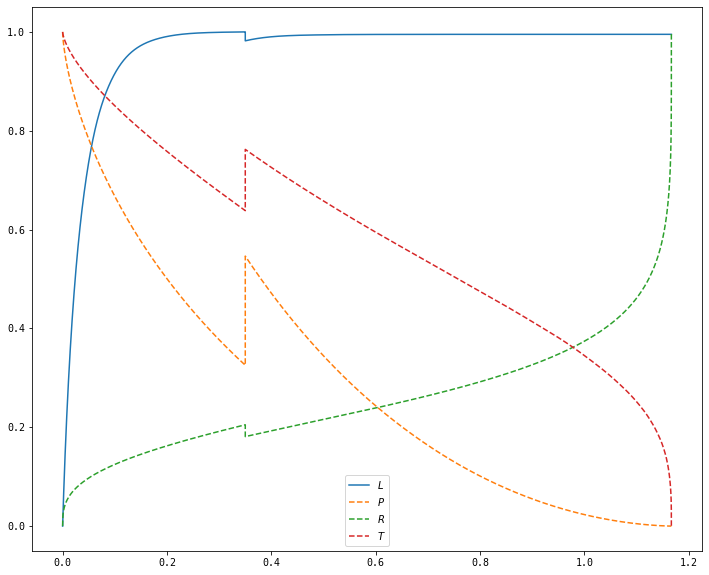

In [895]:
plt.figure(figsize=(12,10))

# plt.plot((np.linspace(1e-12*3.5*Msun, 0.33*3.5*Msun, num = int(1e5)))/M_star,solution[1][0]/solution[1][0].max())
# plt.plot((np.linspace(0.9999*Msun*3.5,0.33*3.5*Msun, num = int(1e5)))/M_star,solution[2][0]/solution[2][0].max())
plt.plot(solution[0][0]/M_star, solution[0][1]/solution[0][1].max(),linestyle= '-', label=r'$L$')

# plt.plot((np.linspace(1e-12*3.5*Msun, 0.33*3.5*Msun, num = int(1e5)))/M_star,solution[1][1]/solution[1][1].max())
# plt.plot((np.linspace(0.9999*Msun*3.5,0.33*3.5*Msun, num = int(1e5)))/M_star,solution[2][1]/solution[2][1].max())
plt.plot(solution[0][0]/M_star, solution[0][2]/solution[0][2].max(),linestyle='--', label=r'$P$')


# plt.plot((np.linspace(1e-12*3.5*Msun, 0.33*3.5*Msun, num = int(1e5)))/M_star,solution[1][2]/solution[1][2].max())
# plt.plot((np.linspace(0.9999*Msun*3.5,0.33*3.5*Msun, num = int(1e5)))/M_star,solution[2][2]/solution[2][2].max())
plt.plot(solution[0][0]/M_star, solution[0][3]/solution[0][3].max(),linestyle= '--', label=r'$R$')

# plt.plot((np.linspace(1e-12*3.5*Msun, 0.33*3.5*Msun, num = int(1e5)))/M_star,solution[1][3]/solution[1][3].max())
# plt.plot((np.linspace(0.9999*Msun*3.5,0.33*3.5*Msun, num = int(1e5)))/M_star,solution[2][3]/solution[2][3].max())
plt.plot(solution[0][0]/M_star, solution[0][4]/solution[0][4].max(),linestyle= '--', label=r'$T$')

plt.legend()


In [624]:
[10**2.711538*Lsun, rho_PgPrad(10**1.055688,10**7.335298),10**0.5*Rsun,10**7.33598]

[1.9691688888961275e+36,
 2.4844228492782844e+16,
 220094525147.7192,
 21676042.80655094]

In [898]:
test=solv([10**2.711538*Lsun, rho_PgPrad(10**1.055688,10**7.335298),10**0.5*Rsun,10**7.33598],3.5*Msun,0.3,int(1e5),1e-12,0.9999)

1.9691688888961275e+36 2.4844228492782844e+16 220094525147.7192 21676042.80655094


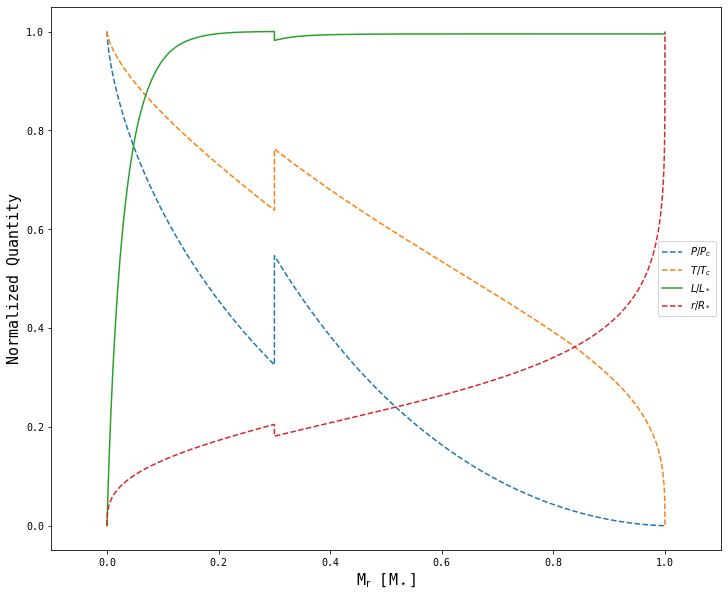

In [1010]:
# plotting
import matplotlib.pyplot as plt
# import seaborn as sb
# sb.set_context("talk")
# plt.style.use('dark_background')
# plt.style.use('default')
plt.rcParams['font.family'] = 'monospace'   # Fonts
plt.rcParams['font.monospace'] = 'DejaVu Sans Mono'

# guesses
# surface
M_star = 3.5*Msun
L_star = (M_star/Msun)**(3.5)*Lsun # eq. 1.88 HKT
R_star = (M_star/Msun)**(0.75)*Rsun # eq. 1.87 HKT
# core
Pc = (3/(8*np.pi))*(G*(M_star)**2)/(R_star)**4 # constant density sphere, lower limit!
Tc = (1/2)*((4/(3+5*0.7))/(Na*k))*(G*M_star)/(R_star) # constant density sphere

# load solution
solution = np.load('converged_interior_{}.npy'.format(M_star/Msun),allow_pickle=True)
# correct L,R_star based on printed output
R_star *= 1
L_star *=  5.0246096593177745
# Pc *= 186.91729635206187
# Tc *= 2.218474387994464


# first plot
# a figure like 9.1 in HKT but in mass space, y-values near 1
plt.figure(figsize=(12,10))

# plt.plot(solution[0]/M_star, solution[5]/solution[5].max(), color='cornflowerblue', label=r'$\rho~[g/cm^3]$'.format())
plt.plot(solution[0][0]/M_star, solution[0][2]/solution[0][2].max(),linestyle= '--', label=r'$P/P_c$')
plt.plot(solution[0][0]/M_star, solution[0][4]/solution[0][4].max(), linestyle= '--',label='$T/T_c$')
plt.plot(solution[0][0]/M_star, solution[0][1]/solution[0][1].max(),label=r'$L/L_*$')
plt.plot(solution[0][0]/M_star, solution[0][3]/solution[0][3].max(),linestyle= '--', label=r'$r/R_*$')


plt.xlabel(r'M$_\mathrm{r}$ [M$_\star$]',fontsize=15)
plt.ylabel(r'Normalized Quantity', fontsize=15)
plt.legend(fontsize=13, bbox_to_anchor=(0.55,0.5))
plt.xlim(-0.1,1.1)
plt.legend(loc='best')

# plt.savefig('./figures/run_over_mass_alt_{}.png'.format(M_star/c.Ms), dpi=300, bbox_inches='tight', transparent=True)
